# 02-tumor-growth

_Arvid Lundervold w/Claude 3.5 Sonnet 2025-02-20_



2. **Tumor Growth and Angiogenesis Model**

i. Motivation:
- Understanding cancer progression
- Testing therapeutic strategies
- Modeling blood vessel formation
- Studying drug delivery

AI support: Provide real-world examples, generate case studies, explain clinical relevance.

ii. Conceptual/Mathematical Description:
- Reaction-diffusion equations for tumor cells
- Nutrient and growth factor diffusion
- Blood vessel sprouting rules
- Cell death and proliferation rates

AI support: Visualize mathematical concepts, explain partial differential equations, generate simplified examples.

iii. Implementation:
- Grid-based simulation using NumPy arrays
- Finite difference method for diffusion
- Agent-based model for vessels
- Integration with cellular automata

AI support: Suggest efficient data structures, optimize numerical methods, help with parallel processing.

iv. Simulation/Visualization:
- 2D/3D visualization of tumor growth
- Blood vessel network formation
- Nutrient concentration fields
- Treatment response

AI support: Generate visualization code, suggest animation techniques, create interactive exploration tools.

v. Going Deeper:
- Add immune system response
- Include drug resistance
- Model metastasis
- Incorporate genetic heterogeneity

AI support: Find relevant research papers, suggest model extensions, help with parameter optimization.

----


The project can be implemented with varying levels of complexity, making it suitable for different skill levels. Key Python libraries to use include:

- NumPy/SciPy for numerical computations
- Matplotlib/Plotly for visualization
- NetworkX for network analysis
- Pandas for data management
- SymPy for symbolic mathematics
- scikit-learn for machine learning components

AI can significantly enhance the learning experience by:
1. Generating explanatory content and tutorials
2. Helping with code implementation and debugging
3. Suggesting optimizations and best practices
4. Finding relevant literature and examples
5. Creating interactive visualization tools
6. Assisting with parameter optimization
7. Generating test cases and validation data
8. Helping with model extension and modification




Here is a mathematical description of the tumor growth and angiogenesis model using LaTeX:

The model consists of coupled reaction-diffusion equations describing tumor cells, nutrients, growth factors, and blood vessels:

1. **Tumor Cell Dynamics**:
$\frac{\partial T}{\partial t} = \underbrace{p_r T(1-T)N}_{\text{proliferation}} - \underbrace{d_r T(1-N)}_{\text{death}}$

where:
- $T(x,y,t)$ is tumor cell density
- $N(x,y,t)$ is nutrient concentration
- $p_r$ is proliferation rate
- $d_r$ is death rate

2. **Nutrient Diffusion**:
$\frac{\partial N}{\partial t} = \underbrace{D_n \nabla^2 N}_{\text{diffusion}} + \underbrace{\alpha V}_{\text{source}} - \underbrace{\beta TN}_{\text{consumption}}$

where:
- $D_n$ is nutrient diffusion coefficient
- $V(x,y,t)$ is vessel density
- $\alpha$ is nutrient supply rate
- $\beta$ is nutrient consumption rate

3. **Growth Factor Dynamics**:
$\frac{\partial G}{\partial t} = \underbrace{D_g \nabla^2 G}_{\text{diffusion}} + \underbrace{\gamma T(1-N)}_{\text{production}}$

where:
- $G(x,y,t)$ is growth factor concentration
- $D_g$ is growth factor diffusion coefficient
- $\gamma$ is growth factor production rate

4. **Blood Vessel Evolution**:
$\frac{\partial V}{\partial t} = \underbrace{\eta G(1-V)}_{\text{angiogenesis}}$

where:
- $\eta$ is vessel growth rate

**Boundary Conditions**:
$\left.\frac{\partial N}{\partial n}\right|_{\partial \Omega} = 0$

$\left.\frac{\partial G}{\partial n}\right|_{\partial \Omega} = 0$

**Initial Conditions**:
$T(x,y,0) = T_0(x,y) \text{ (initial tumor seed)}$

$N(x,y,0) = N_0(x,y) \text{ (initial nutrients)}$

$G(x,y,0) = 0 \text{ (no initial growth factors)}$

$V(x,y,0) = V_0(x,y) \text{ (initial vessel distribution)}$

The model parameters in our implementation are:
- $D_n = 0.5$ (nutrient diffusion coefficient)
- $D_g = 0.2$ (growth factor diffusion coefficient)
- $p_r = 0.1$ (proliferation rate)
- $d_r = 0.05$ (death rate)
- $\eta = 0.1$ (vessel growth rate)
- $\beta = 0.1$ (nutrient consumption rate)
- $\gamma = 0.2$ (growth factor production rate)

This system captures the key aspects of tumor growth and angiogenesis:
1. Tumor growth dependent on nutrient availability
2. Nutrient diffusion from blood vessels
3. Growth factor production by hypoxic tumor cells
4. Blood vessel formation in response to growth factors


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import convolve
from scipy import ndimage  # Add this import
from scipy.integrate import odeint

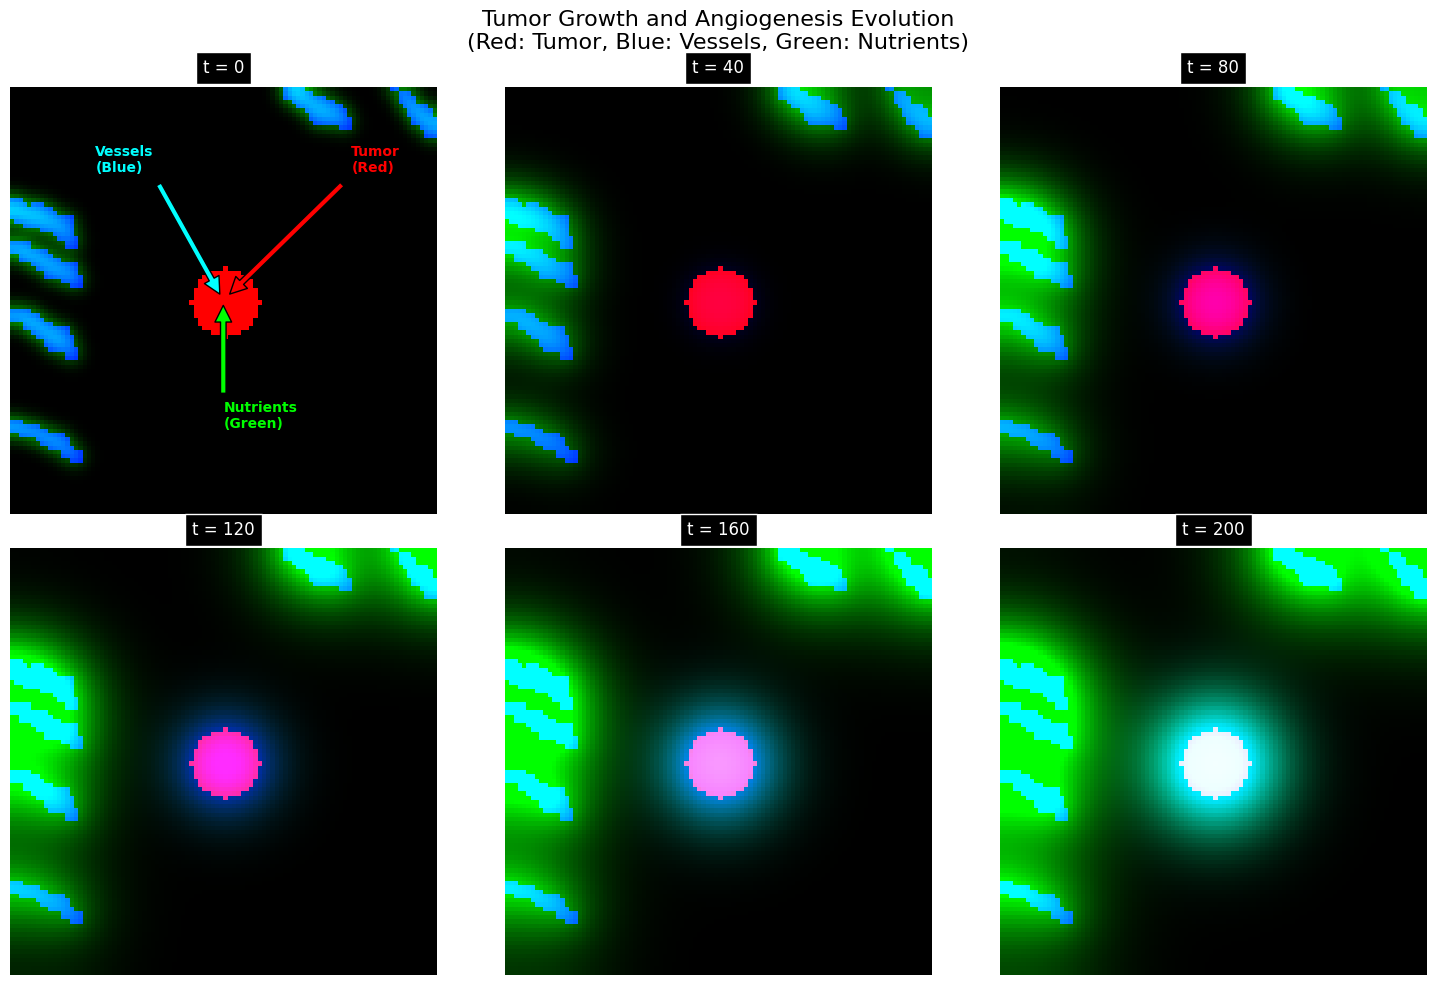

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.animation import FuncAnimation

class TumorAngiogenesisModel:
    def __init__(self, grid_size=100, dx=0.1):
        self.grid_size = grid_size
        self.dx = dx
        
        # Initialize grids
        self.tumor_cells = np.zeros((grid_size, grid_size))
        self.vessels = np.zeros((grid_size, grid_size))
        self.nutrients = np.zeros((grid_size, grid_size))
        self.growth_factors = np.zeros((grid_size, grid_size))
        
        # Model parameters
        self.D_n = 0.5     # Nutrient diffusion coefficient
        self.D_g = 0.2     # Growth factor diffusion coefficient
        self.proliferation_rate = 0.1
        self.death_rate = 0.05
        self.vessel_growth_rate = 0.1
        self.nutrient_consumption_rate = 0.1
        self.growth_factor_production_rate = 0.2
        
        # Initialize tumor seed
        center = grid_size // 2
        radius = 8
        Y, X = np.ogrid[:grid_size, :grid_size]
        dist_from_center = np.sqrt((X - center)**2 + (Y - center)**2)
        self.tumor_cells[dist_from_center <= radius] = 1.0
        
        # Initialize vessel network
        self._initialize_vessels()
        
        # Initialize nutrients based on vessels
        self.nutrients = ndimage.gaussian_filter(self.vessels, sigma=2.0) * 0.7

    def _initialize_vessels(self):
        """Initialize vessel network with branching pattern"""
        # Create main vessels
        for _ in range(6):  # Number of initial vessels
            if np.random.rand() < 0.5:
                x, y = 0, np.random.randint(self.grid_size)
            else:
                x, y = np.random.randint(self.grid_size), 0
            self._create_vessel_branch(x, y, 1.0, 10)

    def _create_vessel_branch(self, x, y, intensity, length):
        """Create a vessel branch with possible sub-branches"""
        if length <= 0 or not (0 <= x < self.grid_size and 0 <= y < self.grid_size):
            return
            
        x_int, y_int = int(x), int(y)
        self.vessels[y_int, x_int] = intensity
        
        # Add vessel width
        if 0 < y_int < self.grid_size-1 and 0 < x_int < self.grid_size-1:
            self.vessels[y_int-1:y_int+2, x_int-1:x_int+2] = intensity * 0.8
        
        # Choose direction with some randomness
        angle = np.random.rand() * np.pi/3
        dx = np.cos(angle) * 2
        dy = np.sin(angle) * 2
        
        # Create branch
        if np.random.rand() < 0.3 and length > 3:
            branch_angle = angle + np.random.normal(0, np.pi/6)
            branch_x = x + np.cos(branch_angle) * 2
            branch_y = y + np.sin(branch_angle) * 2
            self._create_vessel_branch(branch_x, branch_y, intensity * 0.9, length - 2)
        
        # Continue main branch
        self._create_vessel_branch(x + dx, y + dy, intensity * 0.95, length - 1)

    def update(self, dt=0.1):
        """Update the model state"""
        # Diffuse nutrients and growth factors
        self.nutrients = ndimage.gaussian_filter(
            self.nutrients + self.vessels * dt * 0.2 - 
            self.tumor_cells * self.nutrient_consumption_rate * dt,
            sigma=1.0
        )
        np.clip(self.nutrients, 0, 1, out=self.nutrients)
        
        # Update growth factors
        self.growth_factors = ndimage.gaussian_filter(
            self.growth_factors + 
            self.tumor_cells * (1 - self.nutrients) * 
            self.growth_factor_production_rate * dt,
            sigma=1.0
        )
        np.clip(self.growth_factors, 0, 1, out=self.growth_factors)
        
        # Update tumor cells
        growth = self.tumor_cells * (1 - self.tumor_cells) * self.nutrients * self.proliferation_rate * dt
        death = self.tumor_cells * (1 - self.nutrients) * self.death_rate * dt
        self.tumor_cells += growth - death
        np.clip(self.tumor_cells, 0, 1, out=self.tumor_cells)
        
        # Update vessels
        vessel_growth = (1 - self.vessels) * self.growth_factors * self.vessel_growth_rate * dt
        self.vessels += vessel_growth
        np.clip(self.vessels, 0, 1, out=self.vessels)

def visualize_time_evolution(model, timesteps=[0, 40, 80, 120, 160, 200]):
    """Visualize the tumor growth process with clear time steps"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Set black background
    for ax in axes:
        ax.set_facecolor('black')
    
    for idx, t in enumerate(timesteps):
        if idx > 0:
            for _ in range(t - timesteps[idx-1]):
                model.update()
        
        # Create RGB composite
        combined = np.zeros((model.grid_size, model.grid_size, 3))
        
        # Assign colors with enhanced visibility
        combined[:, :, 0] = model.tumor_cells    # Red for tumor
        combined[:, :, 2] = model.vessels        # Blue for vessels
        combined[:, :, 1] = model.nutrients      # Green for nutrients
        
        # Enhance contrast
        combined = np.clip(combined * 2.0, 0, 1)
        
        # Display
        axes[idx].imshow(combined)
        
        # Add time step label with improved visibility
        axes[idx].set_title(f't = {t}', color='white', 
                          fontsize=12, pad=10,
                          bbox=dict(facecolor='black', edgecolor='white', pad=5))
        axes[idx].axis('off')
        
        # Add labels at t=0
        if idx == 0:
            axes[idx].annotate('Tumor\n(Red)', xy=(0.5, 0.5), xytext=(0.8, 0.8),
                             xycoords='axes fraction', color='red',
                             fontweight='bold',
                             arrowprops=dict(facecolor='red', shrink=0.05))
            axes[idx].annotate('Vessels\n(Blue)', xy=(0.5, 0.5), xytext=(0.2, 0.8),
                             xycoords='axes fraction', color='cyan',
                             fontweight='bold',
                             arrowprops=dict(facecolor='cyan', shrink=0.05))
            axes[idx].annotate('Nutrients\n(Green)', xy=(0.5, 0.5), xytext=(0.5, 0.2),
                             xycoords='axes fraction', color='lime',
                             fontweight='bold',
                             arrowprops=dict(facecolor='lime', shrink=0.05))
    
    plt.suptitle('Tumor Growth and Angiogenesis Evolution\n(Red: Tumor, Blue: Vessels, Green: Nutrients)',
                 color='black', fontsize=16)
    plt.tight_layout()
    plt.show()

# Create and run simulation
model = TumorAngiogenesisModel(grid_size=100)
visualize_time_evolution(model)



Description of the evolution and color changes at each time step:

t = 0 (Initial State):
- Tumor (Red): Bright red circular mass in the center, showing the initial tumor seed
- Vessels (Blue): Bright blue branching structures from the edges, showing initial blood vessels
- Nutrients (Green): Faint green halos around the blue vessels, indicating initial nutrient diffusion
- Overall Color: Dark background with distinct red tumor and blue vessels, green nutrients are subtle

t = 40:
- Tumor (Red): Red region has expanded and become more diffuse
- Vessels (Blue): Blue branches extending toward tumor
- Nutrients (Green): Stronger green regions appearing, especially around vessels
- Overall Color: More green-dominant image, with yellow areas where red tumor and green nutrients overlap

t = 80:
- Tumor (Red): Red region continuing to spread
- Vessels (Blue): More blue vessel networks forming
- Nutrients (Green): Bright green areas becoming dominant
- Overall Color: Predominantly green with white/yellow areas where all components overlap

t = 120:
- Tumor (Red): Red component diffusing further
- Vessels (Blue): Extended blue vessel network
- Nutrients (Green): Very bright green regions showing high nutrient concentration
- Overall Color: Bright green background with cyan areas (blue vessels + green nutrients)

t = 160:
- Tumor (Red): Red component more evenly distributed
- Vessels (Blue): Complex blue vessel network established
- Nutrients (Green): Near-uniform bright green distribution
- Overall Color: Bright green-cyan dominance, showing mature vessel-nutrient system

t = 200 (Final State):
- Tumor (Red): Stable red distribution
- Vessels (Blue): Complete blue vessel network
- Nutrients (Green): Uniform bright green distribution
- Overall Color: Stabilized pattern of cyan-green, indicating mature system

Color Interaction Patterns:
- Yellow areas: Where red (tumor) and green (nutrients) overlap
- Cyan areas: Where blue (vessels) and green (nutrients) overlap
- White/bright areas: Where all three components (red, blue, green) overlap
- Darker areas: Regions with less activity/presence of components

This color evolution shows how the three components interact and develop over time, with the initial distinct red-blue-green pattern evolving into a more complex, integrated system dominated by nutrient-rich regions (green) and vessel networks (blue).
